In this notebook we will check for inconsistencies in the dataset:
- prices between no-arbitrage bounds
- put-call-parity
- negative time values

In [1]:
@time include("../startup_script2.jl");

elapsed time: 0.484032252 seconds (52396500 bytes allocated, 6.95% gc time)
elapsed time: 58.465181307 seconds (5419744236 bytes allocated, 74.31% gc time)
elapsed time: 0.749374978 seconds (112671656 bytes allocated, 59.83% gc time)
elapsed time: 79.579483452 seconds (5419744236 bytes allocated, 79.76% gc time)
elapsed time: 164.58439742 seconds (14793985640 bytes allocated, 67.47% gc time)


### Bounds

- for non-dividend-paying stocks we get the following bounds

$$\max (S_{0} - Ke^{-rT}, 0) \leq c \leq S_{0}$$
$$ \max (Ke^{-rT} - S_{0}, 0) \leq p \leq Ke^{-rT}$$

- create required data matrix

In [2]:
consistData = join(optPrices, opts, on = :ID) |>
x -> join(x, cohortParams, on = [:Date, :Expiry]) |>
x -> join(x, daxVals, on = :Date)

head(consistData)

,Date,ID,Price,Expiry,Strike,IsCall,EONIA_matched,Time_to_Maturity,DAX
1,2006-07-03,c_20060721_4500,1212.0,2006-07-21,4500,true,0.0283102283088403,0.0549019607843137,5712.69
2,2006-07-03,c_20060721_4600,1112.3,2006-07-21,4600,true,0.0283102283088403,0.0549019607843137,5712.69
3,2006-07-03,c_20060721_4700,1012.7,2006-07-21,4700,true,0.0283102283088403,0.0549019607843137,5712.69
4,2006-07-03,c_20060721_4800,913.2,2006-07-21,4800,true,0.0283102283088403,0.0549019607843137,5712.69
5,2006-07-03,c_20060721_4850,863.5,2006-07-21,4850,true,0.0283102283088403,0.0549019607843137,5712.69
6,2006-07-03,c_20060721_4900,813.9,2006-07-21,4900,true,0.0283102283088403,0.0549019607843137,5712.69


In [3]:
function callLowBound(s::Float64, k::Int, r::Float64, T::Float64)
    return maximum([s - k*exp(-r*T), 0])
end

function putLowBound(s::Float64, k::Int, r::Float64, T::Float64)
    return maximum([k*exp(-r*T - s), 0])
end

putLowBound (generic function with 1 method)

In [4]:
function priceBounds(x::DataFrame)
    nObs = size(x, 1)
    lowBounds, upBounds = (zeros(nObs), zeros(nObs))
    for ii=1:nObs
        if x[ii, :IsCall]
            lowBounds[ii] = callLowBound(x[ii, :DAX], x[ii, :Strike], x[ii, :EONIA_matched], x[ii, :Time_to_Maturity])
            upBounds[ii] = x[ii, :DAX]
        else
            lowBounds[ii] = putLowBound(x[ii, :DAX], x[ii, :Strike], x[ii, :EONIA_matched], x[ii, :Time_to_Maturity])
            upBounds[ii] = x[ii, :Strike]*exp(-x[ii, :EONIA_matched]*x[ii, :Time_to_Maturity])
        end
    end
    return (lowBounds, upBounds)         
end            

priceBounds (generic function with 1 method)

In [5]:
lowBounds, upBounds = priceBounds(consistData)

([1219.68,1119.83,1019.99,920.145,870.222,820.3,770.378,720.455,670.533,620.611  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[5712.69,5712.69,5712.69,5712.69,5712.69,5712.69,5712.69,5712.69,5712.69,5712.69  …  9199.56,9249.29,9348.75,9398.47,9448.2,9497.93,9547.65,9647.11,9746.56,9846.02])

In [6]:
consistData[:LowBound] = lowBounds
consistData[:UpBound] = upBounds

head(consistData)

,Date,ID,Price,Expiry,Strike,IsCall,EONIA_matched,Time_to_Maturity,DAX,LowBound,UpBound
1,2006-07-03,c_20060721_4500,1212.0,2006-07-21,4500,true,0.0283102283088403,0.0549019607843137,5712.69,1219.678858946394,5712.69
2,2006-07-03,c_20060721_4600,1112.3,2006-07-21,4600,true,0.0283102283088403,0.0549019607843137,5712.69,1119.8341669229812,5712.69
3,2006-07-03,c_20060721_4700,1012.7,2006-07-21,4700,true,0.0283102283088403,0.0549019607843137,5712.69,1019.9894748995675,5712.69
4,2006-07-03,c_20060721_4800,913.2,2006-07-21,4800,true,0.0283102283088403,0.0549019607843137,5712.69,920.1447828761538,5712.69
5,2006-07-03,c_20060721_4850,863.5,2006-07-21,4850,true,0.0283102283088403,0.0549019607843137,5712.69,870.2224368644474,5712.69
6,2006-07-03,c_20060721_4900,813.9,2006-07-21,4900,true,0.0283102283088403,0.0549019607843137,5712.69,820.3000908527401,5712.69


- frequency of option prices below option lower bound

In [7]:
nObs = size(consistData, 1)
sum(consistData[:Price] .< consistData[:LowBound])/nObs

0.031203444323793694

- frequency of option prices above upper bound

In [8]:
sum(consistData[:Price] .> consistData[:UpBound])/nObs

0.0

#### Properties of option prices outside of bounds

- call / put ratio

In [9]:
inconsistPrices = consistData[:Price] .< consistData[:LowBound]

nInconCalls = sum(consistData[:IsCall] & inconsistPrices)/nObs
nInconPuts = sum(!consistData[:IsCall] & inconsistPrices)/nObs

(nInconCalls, nInconPuts)

(0.031203444323793694,0.0)

- all inconsistent prices seem to be call options

In [10]:
inconsistData = consistData[inconsistPrices, :]

head(inconsistData)

,Date,ID,Price,Expiry,Strike,IsCall,EONIA_matched,Time_to_Maturity,DAX,LowBound,UpBound
1,2006-07-03,c_20060721_4500,1212.0,2006-07-21,4500,true,0.0283102283088403,0.0549019607843137,5712.69,1219.678858946394,5712.69
2,2006-07-03,c_20060721_4600,1112.3,2006-07-21,4600,true,0.0283102283088403,0.0549019607843137,5712.69,1119.8341669229812,5712.69
3,2006-07-03,c_20060721_4700,1012.7,2006-07-21,4700,true,0.0283102283088403,0.0549019607843137,5712.69,1019.9894748995675,5712.69
4,2006-07-03,c_20060721_4800,913.2,2006-07-21,4800,true,0.0283102283088403,0.0549019607843137,5712.69,920.1447828761538,5712.69
5,2006-07-03,c_20060721_4850,863.5,2006-07-21,4850,true,0.0283102283088403,0.0549019607843137,5712.69,870.2224368644474,5712.69
6,2006-07-03,c_20060721_4900,813.9,2006-07-21,4900,true,0.0283102283088403,0.0549019607843137,5712.69,820.3000908527401,5712.69


- plotting distances to lower bound

In [11]:
inconsistencies = inconsistData[:LowBound] - inconsistData[:Price]
Gadfly.plot(x = convert(Array, inconsistencies), Geom.histogram)

LoadError: Gadfly not defined
while loading In[11], in expression starting on line 2

- check liquidity:
  - open interest
  - time to maturity
  - moneyness

In [12]:
ttm = inconsistData[:Time_to_Maturity]

63191-element DataArray{Float64,1}:
 0.054902
 0.054902
 0.054902
 0.054902
 0.054902
 0.054902
 0.054902
 0.054902
 0.054902
 0.054902
 0.054902
 0.054902
 0.054902
 ⋮       
 0.227451
 0.227451
 0.227451
 0.227451
 0.227451
 0.227451
 0.227451
 0.227451
 0.227451
 0.227451
 0.227451
 0.227451

- time to maturity distribution for inconsistent observations

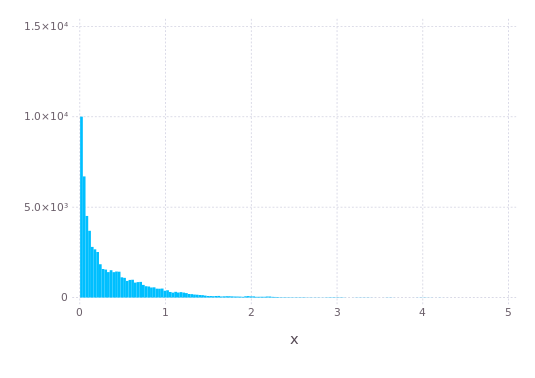

In [13]:
using Gadfly
Gadfly.plot(x=convert(Array, ttm), Gadfly.Geom.histogram)

- time to maturity for all observations

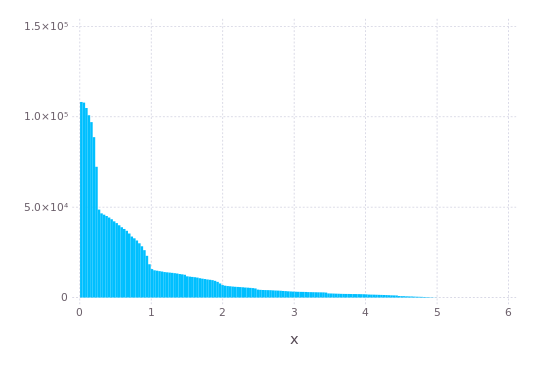

In [14]:
Gadfly.plot(x=convert(Array, consistData[:Time_to_Maturity]), Gadfly.Geom.histogram)

- defining moneyness functions

In [19]:
function absCallMness(s::DataArray{Float64, 1}, k::DataArray{Int, 1})
    return s - k
end

function relCallMness(s::DataArray{Float64, 1}, k::DataArray{Int, 1})
    return s./k
end

function discRelCallMness(s::DataArray{Float64, 1}, k::DataArray{Int, 1}, r::DataArray{Float64, 1}, ttm::DataArray{Float64, 1})
    return s./(exp(-r.*ttm).*k)
end

function tScaledCallMness(s::DataArray{Float64, 1}, k::DataArray{Int, 1}, r::DataArray{Float64, 1}, ttm::DataArray{Float64, 1})
    return (s./(exp(-r.*ttm).*k)./sqrt(ttm))
end

tScaledCallMness (generic function with 2 methods)

- calculate moneynesses

In [23]:
kkk = Array(DataFrame, 2)

2-element Array{DataFrame,1}:
 #undef
 #undef

In [25]:
s = inconsistData[:DAX]
k = inconsistData[:Strike]
r = inconsistData[:EONIA_matched]
ttm = inconsistData[:Time_to_Maturity]

moneynesses = Array(DataFrame, 2)
ind = 1
for dat in (consistData, inconsistData)
    s = dat[:DAX]
    k = dat[:Strike]
    r = dat[:EONIA_matched]
    ttm = dat[:Time_to_Maturity]
    
    absMness = absCallMness(s, k)
    relMness = relCallMness(s, k)
    discMness = discRelCallMness(s, k, r, ttm)
    tScaledMness = tScaledCallMness(s, k, r, ttm)
    
    moneynesses[ind] = DataFrame(absMness = absMness, relMness = relMness, discMness = discMness, tScaledMness = tScaledMness)
    ind = ind + 1
end
    
head(moneynesses[1])

,absMness,relMness,discMness,tScaledMness
1,1212.6899999999996,1.2694866666666667,1.2714613475586398,5.426367894533838
2,1112.6899999999996,1.2418891304347826,1.2438208834812783,5.308403375087451
3,1012.6899999999996,1.2154659574468085,1.2173566093646553,5.195458622426016
4,912.6899999999996,1.1901437499999998,1.191995013336225,5.087219901125474
5,862.6899999999996,1.1778742268041236,1.1797064049513155,5.0347743351344905
6,812.6899999999996,1.1658551020408163,1.1676685844926284,4.983399086816791


In [29]:
[mean(da[2]) for da in eachcol(moneynesses[1])]

4-element Array{Any,1}:
 339.999  
   1.23866
   1.26476
   2.49093

In [30]:
[mean(da[2]) for da in eachcol(moneynesses[2])]

4-element Array{Any,1}:
 3051.4    
    2.77355
    2.8042 
    6.85856

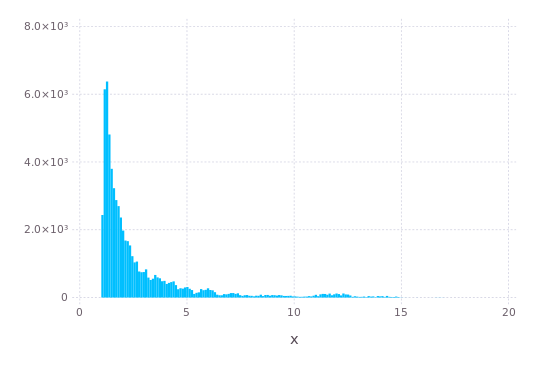

In [31]:
plot(x = moneynesses[2][2], Geom.histogram)

In [35]:
kk = find(moneynesses[2][2] .> 15)
inconsistData[kk[1], :]

,Date,ID,Price,Expiry,Strike,IsCall,EONIA_matched,Time_to_Maturity,DAX,LowBound,UpBound
1,2011-04-29,c_20111216_500,7015.797,2011-12-16,500,true,0.0180245343421659,0.647058823529412,7514.46,7020.2575928044635,7514.46


In [37]:
sum(moneynesses[2][2] .< 0)

0

### Put-Call parity

- checking put-call parity

$$c+Ke^{-rT}=p+S_{0}$$